##  This notebook computes times series that describe the Walker Circulation

### Some of the calculations mirror those used in Chapter 6 of 'The Hadley Circulation: Present, Past and Future' by Chunzai Wang, published in 2005.  

#### in Wang, 2005, three boxes are used to define the Pacific Walker circulation and the Atlantic Walker index.  The Walker index is defined by the difference of the 500 mb vertical velocity anomaly between the equatorial east Pacific and the equatorial western Pacific (see Figure 6-4 of Wang.  The Atlantic Walker circulation index is defined by the 500 mb vertical velocity anomalies in the region of 2.5S:2.5N; 40W:20W (See Figure 6-6).   The boxes are as defined below: 


##### box1 covers 160W:120W; 5S:5N --> equatorial eastern Pacific
##### box2 covers 120E:160E; 5S:5N --> equatorial western Pacific 
##### box3 covers 40W:20W; 5S:5N   --> equatorial Atlantic 

In [1]:
using CairoMakie
using GeoMakie
using NCDatasets
using Statistics
using GLM
using Polynomials
using DataFrames
using CSV

include("ensoFuncs.jl")

test_num_nina (generic function with 1 method)

In [38]:
path="/Users/C823281551/data/ERA5/"
file1   = path*"era5_omega_pv_vort_500hPa_1990th2024_360x180.nc"
file2   = path*"era5_sst_1990th2024_360x180.nc"
tag = "ERA5 July"
data   = NCDataset(file1);
data2  = NCDataset(file2);
#
lat = data["lat"]
lon = data["lon"]
tme = data["valid_time"]
wap = data["w"]
sst = data2["sst"]
lat2 = data2["lat"]
lon2 = data2["lon"]
#
dims = size(wap)

(360, 180, 1, 420)

In [3]:
lon2[61]

-120.0

#### Compute both the Oceanic Nino Index (ONI) and the Relative ONI (RONI) from nino3.4

In [4]:
# the tropics we are defining are: +/-20 degrees
#
# the nino 3.4 region is 
# 120-170W; -5S:5N

## compute RONI from the ERA5 SST data
#enso3p4_mn = mean(c1)
#nino3p4_anom = c1 .- enso3p4_mn
#tp_mn = mean(c2)
#tp_anom = c2 .- tp_mn

inpFile = file2;
###
timelen = 420
#inpFile = file1
println("~~~~~~~~~~~~~~~~~~file 1~~~~~~~~~~~~~~~~~~~~~~")
println(inpFile)
println("""~~~~~~~~~~~~~~~~~~>>>>>>~~~~~~~~~~~~~~~~~~~~~~""")
lat1 = 71
lat2 = 111
lon34a = 11
lon34b = 61
lat34a = 86
lat34b = 96

calc_roni_cmip_ts(inpFile,timelen,lat1,lat2,lon34a,lon34b,lat34a,lat34b);
roni_era5 = ts_rmn;
#ba1nn = ts_rmn2;
###

###

## smooth the era5 roni time-series
smooth_ts(roni_era5,420)
blah3 = ts_sm

~~~~~~~~~~~~~~~~~~file 1~~~~~~~~~~~~~~~~~~~~~~
/Users/C823281551/data/ERA5/era5_sst_1990th2024_360x180.nc
~~~~~~~~~~~~~~~~~~>>>>>>~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~ nino34 long points: ~~~~~~~~~~~~~~~~
[-170.0, -169.0, -168.0, -167.0, -166.0, -165.0, -164.0, -163.0, -162.0, -161.0, -160.0, -159.0, -158.0, -157.0, -156.0, -155.0, -154.0, -153.0, -152.0, -151.0, -150.0, -149.0, -148.0, -147.0, -146.0, -145.0, -144.0, -143.0, -142.0, -141.0, -140.0, -139.0, -138.0, -137.0, -136.0, -135.0, -134.0, -133.0, -132.0, -131.0, -130.0, -129.0, -128.0, -127.0, -126.0, -125.0, -124.0, -123.0, -122.0, -121.0, -120.0]
~~~~~ nino34 lat points: ~~~~~~~~~~~~~~~~
[-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
~~~~~tropical boundary lat points: ~~~~~~~~~~~~~~~~
[-20.0, -19.0, -18.0, -17.0, -16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 

420-element Vector{Float64}:
  0.2599432336524215
  0.2599432336524215
  0.2881130378312438
  0.31305685861144594
  0.30753184190684424
  0.2901363481545546
  0.29193550369279864
  0.3312538009021698
  0.3482203081194329
  0.3536631841496481
  0.3800865403741225
  0.44508516390113134
  0.47618664051076776
  ⋮
  1.1525576752191118
  0.9450074298525232
  0.6254460362489778
  0.26785642358236506
 -0.06192535483182902
 -0.2539989535731488
 -0.3884457308344476
 -0.5271688701980554
 -0.688346434275268
 -0.8263926569329642
 -0.8984370658798259
 -0.8984370658798259

In [5]:
# now compute RONI from the Observations (presumably from NOAA?)

# incoming data in csv format:
# this data spans the years 1854 through the end of 2023
file7 = "/Users/C823281551/data/obs/observed_nino3.4.csv"
file8 = "/Users/C823281551/data/obs/observed_tropicalmean.csv"
df1 = CSV.read(file7, header = 0, footerskip = 0, DataFrame)
df2 = CSV.read(file8, header = 0, footerskip = 0, DataFrame)
nms = ["year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
dfa  = DataFrame(df1, nms)
dfb  = DataFrame(df2, nms)
istart = 2
iend   = 170 # years
# this is necessary because of the weird structure of dataframes (1 year per row)
for i in istart:iend
    if i < istart + 1
        global a1 = collect(df1[istart-1, 2:13]) # observed nino3.4
        global a2 = collect(df2[istart-1, 2:13]) # observed tr mn
    end
    b1 = collect(df1[i, 2:13]) # grab a row of the DataFrame and convert to vector
    b2 = collect(df2[i, 2:13]) # grab a row of the DataFrame and convert to vector
    global c1 = [a1; b1] # concatinate two vectors of observed nino3.4
    global c2 = [a2; b2] # concatinate two vectors of observed tropical mean
    a1 = c1
    a2 = c2
end

#### Compute both the Oceanic Nino Index (ONI) and the Relative ONI (RONI) from nino3.4

enso3p4_mn = mean(c1)
nino3p4_anom = c1 .- enso3p4_mn
tp_mn = mean(c2)
tp_anom = c2 .- tp_mn

# remove seasonal cycle
mn_oni = zeros(12)
mn_a = [mean(df1[:,i]) for i in 2:13] # seasonal cycle of nino3.4
mn_b = [mean(df2[:,i]) for i in 2:13] # seasonal cycle of tropical mean
# one can check the seasonal cycle in the REPL with:
# lines(mn_a)
jend = 170*12

c1nsc  = zeros(jend)
c2nsc  = zeros(jend)
roni_a  = zeros(jend)

for i in 1:12:jend
  # remove seasonal cycle of nino3p4
  c1nsc[i]=nino3p4_anom[i]-mn_a[1]
  c1nsc[i+1]=nino3p4_anom[i+1]-mn_a[2]
  c1nsc[i+2]=nino3p4_anom[i+2]-mn_a[3]
  c1nsc[i+3]=nino3p4_anom[i+3]-mn_a[4]
  c1nsc[i+4]=nino3p4_anom[i+4]-mn_a[5]
  c1nsc[i+5]=nino3p4_anom[i+5]-mn_a[6]
  c1nsc[i+6]=nino3p4_anom[i+6]-mn_a[7]
  c1nsc[i+7]=nino3p4_anom[i+7]-mn_a[8]
  c1nsc[i+8]=nino3p4_anom[i+8]-mn_a[9]
  c1nsc[i+9]=nino3p4_anom[i+9]-mn_a[10]
  c1nsc[i+10]=nino3p4_anom[i+10]-mn_a[11]
  c1nsc[i+11]=nino3p4_anom[i+11]-mn_a[12]
  # remove seasonal cycle of tropical mean 
  c2nsc[i]  =tp_anom[i]-mn_b[1]
  c2nsc[i+1]=tp_anom[i+1]-mn_b[2]
  c2nsc[i+2]=tp_anom[i+2]-mn_b[3]
  c2nsc[i+3]=tp_anom[i+3]-mn_b[4]
  c2nsc[i+4]=tp_anom[i+4]-mn_b[5]
  c2nsc[i+5]=tp_anom[i+5]-mn_b[6]
  c2nsc[i+6]=tp_anom[i+6]-mn_b[7]
  c2nsc[i+7]=tp_anom[i+7]-mn_b[8]
  c2nsc[i+8]=tp_anom[i+8]-mn_b[9]
  c2nsc[i+9]=tp_anom[i+9]-mn_b[10]
  c2nsc[i+10]=tp_anom[i+10]-mn_b[11]
  c2nsc[i+11]=tp_anom[i+11]-mn_b[12]
end

sig_oni   = std(c1nsc)   # standard deviation of oni
sig_dif   = std(c1nsc-c2nsc) # standard deviation of tr mean
sig_scale = sig_oni/sig_dif

# calculate a 3 point running mean
ts_oni = zeros(2040)
tmn_sm = zeros(2040)
istart= 2
jend  = 2040
for i in istart:jend-1
  ts_oni[i] = (c1nsc[i+1]+c1nsc[i]+c1nsc[i-1])/3
  tmn_sm[i] = (c2nsc[i+1]+c2nsc[i]+c2nsc[i-1])/3
end
ts_oni[1]    =ts_oni[2]
ts_oni[jend] =ts_oni[jend-1]
tmn_sm[1]    =tmn_sm[2]
tmn_sm[jend] =tmn_sm[jend-1]

roni_a = sig_scale.*(ts_oni - tmn_sm)
smooth_12_ts(roni_a,2040)
blah3 = ts_12_sm

smooth_ts(roni_a,2040)
roni_b = ts_sm

# grab the last few years for comparison: 
shortRoni = roni_b[end-407:end];

In [6]:
2024-1854

170

In [7]:
size(roni_b)

(2040,)

In [8]:
size(shortRoni)

(408,)

In [9]:
pooface = wap[:,:,1,1];

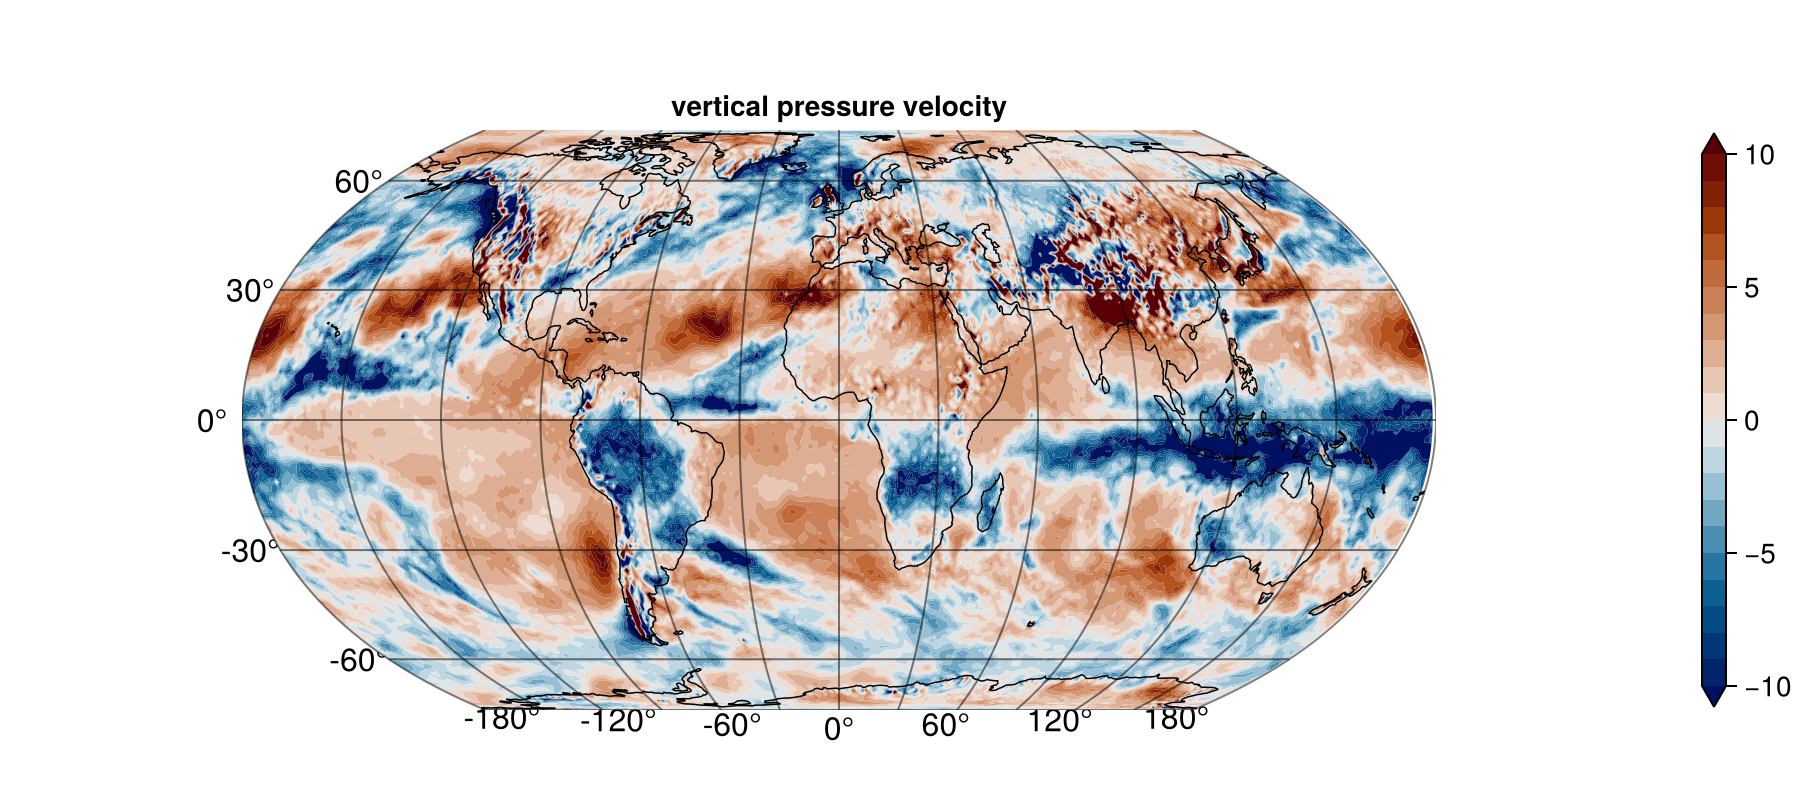

In [10]:
#levs = range(-.02, 0.02, length = 21)
levs = range(-10., 10., length = 21)
blah = fig_anom_plot(100 .* wap[:,:,1,1],lon,lat,"vertical pressure velocity",levs)

In [11]:
#contourf(100 .* wap[:,:,1,1]);

In [39]:
box1      = Array{Union{Missing, Float64}, 4}(undef, 11, 41, 1, dims[4]);
box1_mn   = Array{Union{Missing, Float64}, 1}(undef, dims[4]);
box1_anom = Array{Union{Missing, Float64}, 1}(undef, dims[4]);
box2      = Array{Union{Missing, Float64}, 4}(undef, 11, 41, 1, dims[4]);
box2_mn   = Array{Union{Missing, Float64}, 1}(undef, dims[4]);
box2_anom = Array{Union{Missing, Float64}, 1}(undef, dims[4]);
box3      = Array{Union{Missing, Float64}, 4}(undef, 5, 20, 1, dims[4]);
box3_mn   = Array{Union{Missing, Float64}, 1}(undef, dims[4]);
box3_anom = Array{Union{Missing, Float64}, 1}(undef, dims[4]);

In [80]:
# index = eastern Pacific minus western Pacific: box1 - box2
box1=100 .* wap[21:61,86:96,1,:];
# box1 covers 160W:120W; 5S:5N --> equatorial eastern Pacific
box2=100 .* wap[301:341,86:96,1,:]; # west pacific box
# box2 covers 120E:160E; 5S:5N --> equatorial western Pacific 
box3=100 .* wap[141:161,89:94,1,:]; # Atlantic box
# box3 covers 40W:20W; 5S:5N
size(box3)

(21, 6, 420)

In [79]:
## if checking the lat/lon values used to define boxes is desired: 
lat[88:94]
#lon[141:161;

7-element Vector{Float64}:
 -3.0
 -2.0
 -1.0
  0.0
  1.0
  2.0
  3.0

In [56]:
#size(box2)
timeAx  = collect(1990.083333:1/12:2025);
timeAxB = collect(1990.083333:1/12:2024);

In [44]:
size(timeAx)

(420,)

In [76]:
# compute anomolous time series for each of the boxes.
for i in 1:420
    box1_mn[i] = mean(skipmissing(box1[:,:,i]));
    box2_mn[i] = mean(skipmissing(box2[:,:,i]));
    box3_mn[i] = mean(skipmissing(box3[:,:,i]));
end
for i in 1:420
    box1_anom[i] = box1_mn[i] .- mean(box1_mn);
    box2_anom[i] = box2_mn[i] .- mean(box2_mn);
    box3_anom[i] = box3_mn[i] .- mean(box3_mn);
end

In [59]:
# apply a 3 point running mean smoothing filter
smooth_ts(box1_mn,420)
box1_mn_sm = ts_sm;
smooth_ts(box2_mn,420)
box2_mn_sm = ts_sm;
smooth_ts(box3_mn,420)
box3_mn_sm = ts_sm;
# compute the Pacific Walker Circulation:
walk_pac = box1_mn_sm .- box2_mn_sm;
# smooth the anomolous time series:
smooth_ts(box1_anom,420)
box1_mn_an = ts_sm;
smooth_ts(box2_anom,420)
box2_mn_an = ts_sm;
smooth_ts(box3_anom,420)
box3_mn_an = ts_sm;
# compute the anomolous Pacific Walker Circulation: 
walk_pac_an = box1_mn_an .- box2_mn_an;

In [58]:
#smooth_ts(box1_anom,420)
#box1_mn_an = ts_sm;
#smooth_ts(box2_anom,420)
#box2_mn_an = ts_sm;
#smooth_ts(box3_anom,420)
#box3_mn_an = ts_sm;
## compute the anomolous Pacific Walker Circulation: 
#walk_pac_an = box1_mn_an .- box2_mn_an;

In [48]:
mean(box1_mn)

1.193950151199741

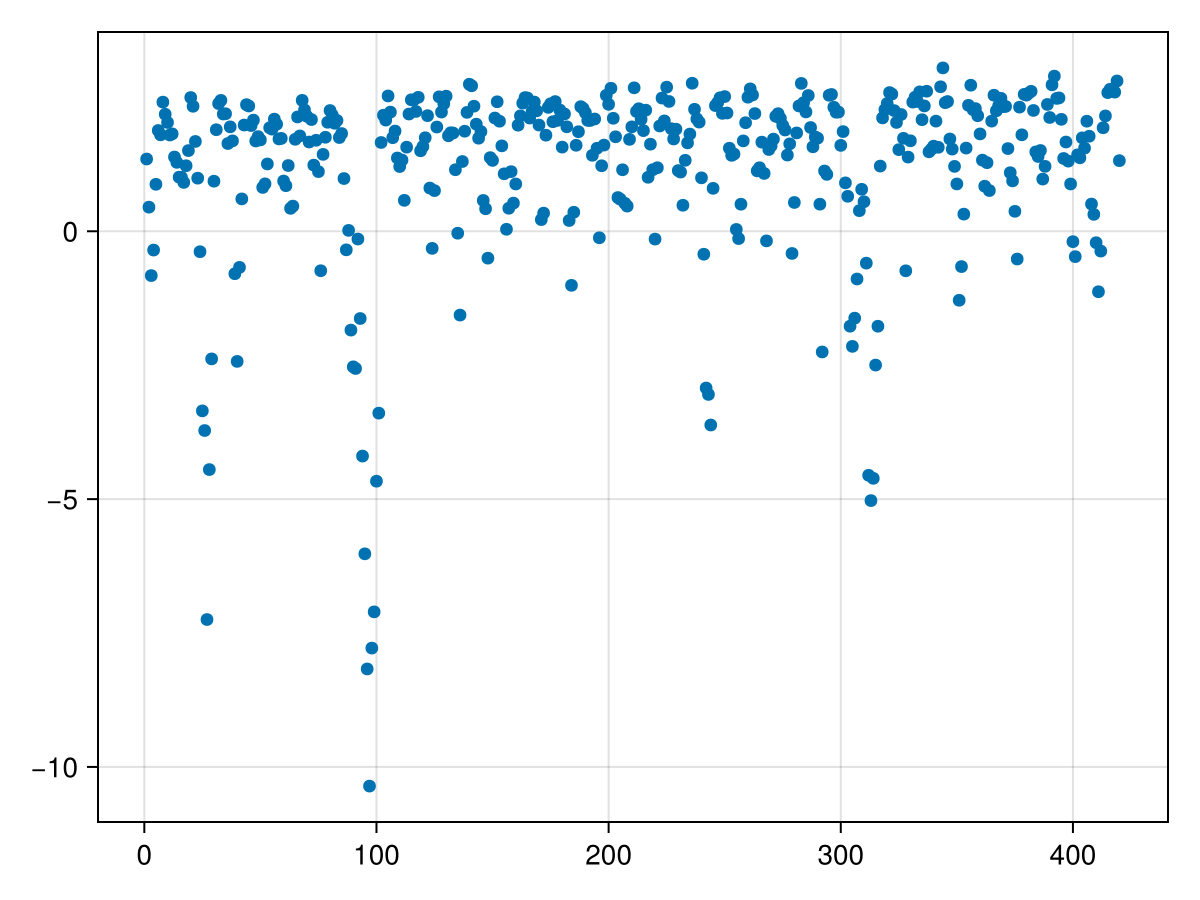

In [49]:
plot(box1_mn)

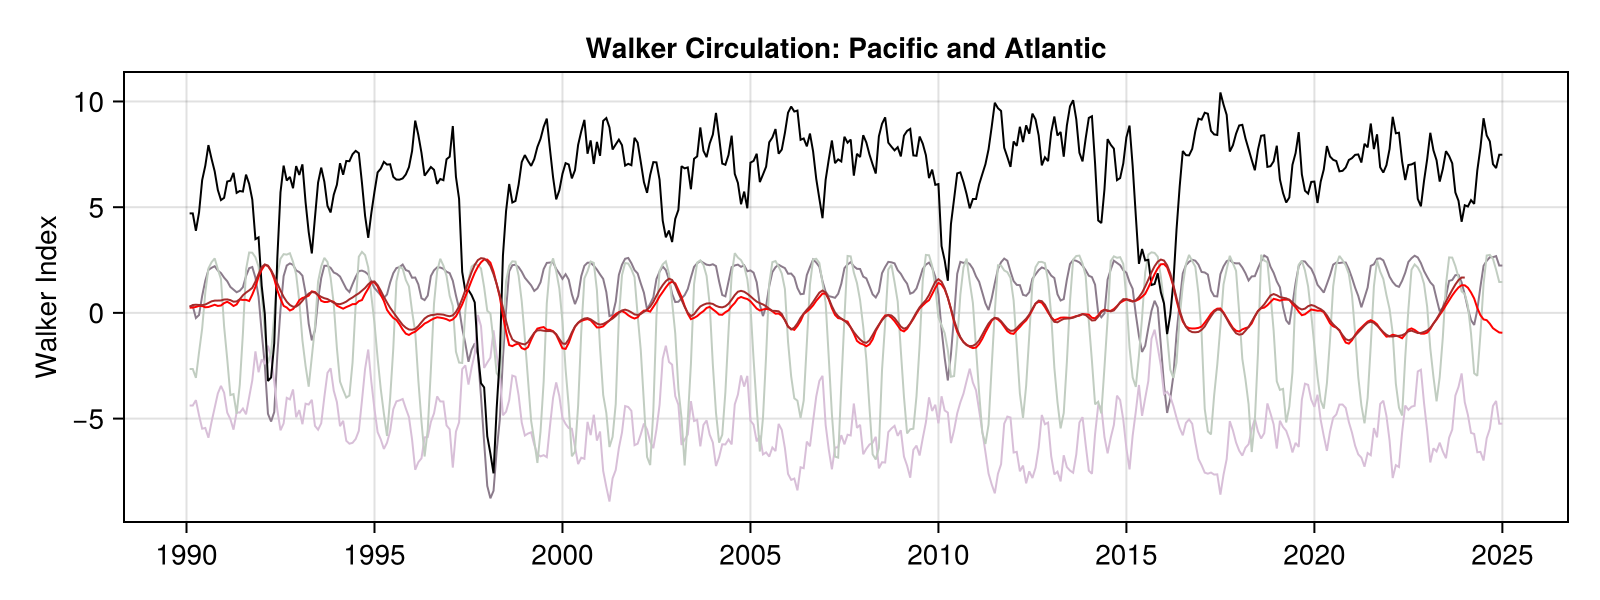

In [50]:
fig = Figure(;
    size = (800,300),
    )
ax = Axis(fig[1,1];
    xlabel=" ",
    ylabel="Walker Index",
    #xticks=([1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]),
    xticks=([1990,1995,2000,2005,2010,2015,2020,2025]),
    title="Walker Circulation: Pacific and Atlantic"
    )
lines!(ax, timeAx,box1_mn_sm[:],
    linewidth = 1.00,
    color = "thistle4",
    label = "box 1"
    )
lines!(ax, timeAx,box2_mn_sm[:],
    linewidth = 1.00,
    color = "thistle",
    label = "box2"
    )
lines!(ax, timeAx,box3_mn_sm[:],
    linewidth = 1.00,
    color = "honeydew3",
    label = "Atlantic Walker"
    )
lines!(ax, timeAx,walk_pac[:],
    linewidth = 1.00,
    color = "black",
    label = "Pacific Walker"
    )
lines!(ax, timeAx,roni_era5[:],
    linewidth = 1.00,
    color = "red",
    label = "RONI era5"
    )
lines!(ax, timeAxB,shortRoni[:],
    linewidth = 1.00,
    color = "brown",
    label = "RONI obs"
    )
#axislegend( position=:rb)
fig

In [51]:
save("testWalkerTSnoAnom.png", fig; px_per_unit=12.0)

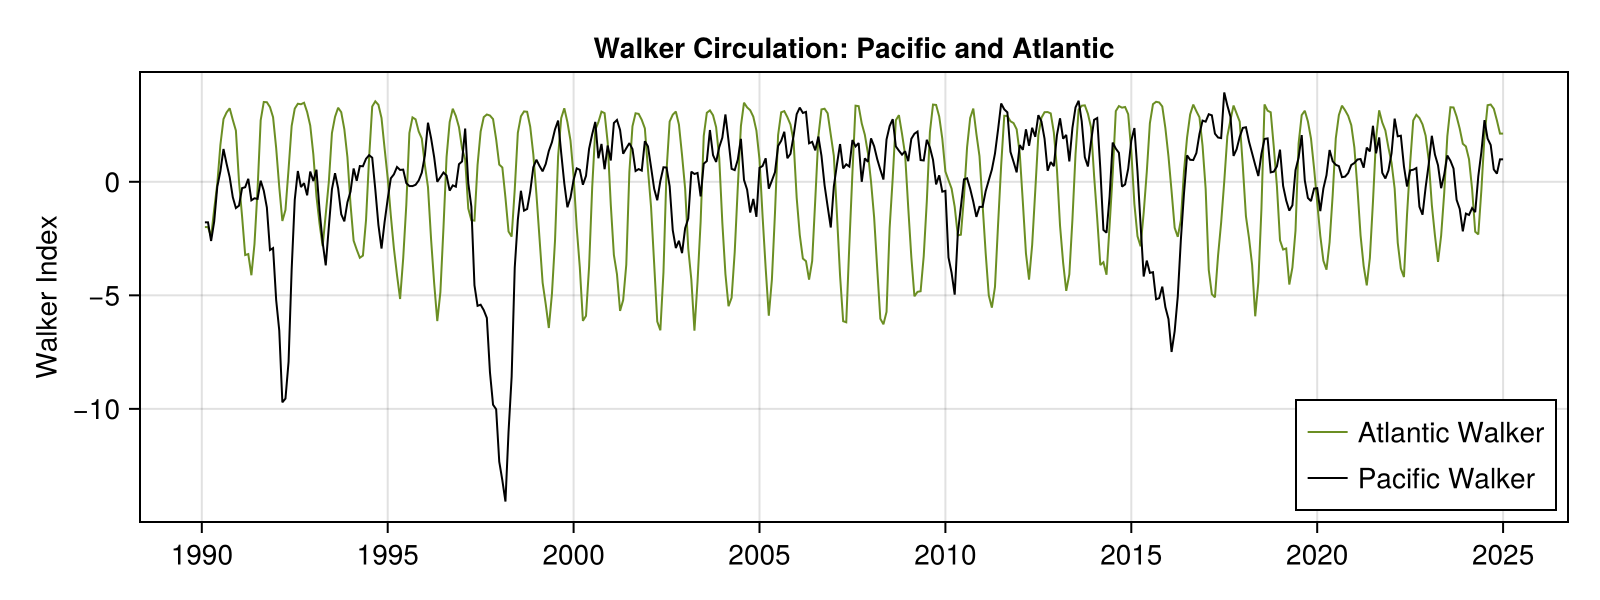

In [52]:
fig = Figure(;
    size = (800,300),
    )
ax = Axis(fig[1,1];
    xlabel=" ",
    ylabel="Walker Index",
    xticks=([1990,1995,2000,2005,2010,2015,2020,2025]),
    title="Walker Circulation: Pacific and Atlantic"
    )
lines!(ax, timeAx,box3_mn_an[:],
    linewidth = 1.00,
    #color = "honeydew3",
    color = "olivedrab",
    label = "Atlantic Walker"
    )
lines!(ax, timeAx,walk_pac_an[:],
    linewidth = 1.00,
    color = "black",
    label = "Pacific Walker"
    )
axislegend( position=:rb)
fig

In [53]:
# to compute the anomalies, as in Wang, 2005, Chapter 6, we need to remove the seasonal cycle.  

tlength = 420;
sst   = zeros(12)
jan   = [mean([box3_mn[i] for i in 1:12:tlength])]
feb   = [mean([box3_mn[i] for i in 2:12:tlength])]
mar   = [mean([box3_mn[i] for i in 3:12:tlength])]
apr   = [mean([box3_mn[i] for i in 4:12:tlength])]
may   = [mean([box3_mn[i] for i in 5:12:tlength])]
jun   = [mean([box3_mn[i] for i in 6:12:tlength])]
jul   = [mean([box3_mn[i] for i in 7:12:tlength])]
aug   = [mean([box3_mn[i] for i in 8:12:tlength])]
sep   = [mean([box3_mn[i] for i in 9:12:tlength])]
oct   = [mean([box3_mn[i] for i in 10:12:tlength])]
nov   = [mean([box3_mn[i] for i in 11:12:tlength])]
dec   = [mean([box3_mn[i] for i in 12:12:tlength])]
ss    = [jan feb mar apr may jun jul aug sep oct nov dec]
global ts_bx3_nsc = zeros(tlength) # time series of nino3.4 without seasonal cycle
for i in 1:12:tlength
   ts_bx3_nsc[i]    = box3_mn[i]    - ss[1]
   ts_bx3_nsc[i+1]  = box3_mn[i+1]  - ss[2]
   ts_bx3_nsc[i+2]  = box3_mn[i+2]  - ss[3]
   ts_bx3_nsc[i+3]  = box3_mn[i+3]  - ss[4]
   ts_bx3_nsc[i+4]  = box3_mn[i+4]  - ss[5]
   ts_bx3_nsc[i+5]  = box3_mn[i+5]  - ss[6]
   ts_bx3_nsc[i+6]  = box3_mn[i+6]  - ss[7]
   ts_bx3_nsc[i+7]  = box3_mn[i+7]  - ss[8]
   ts_bx3_nsc[i+8]  = box3_mn[i+8]  - ss[9]
   ts_bx3_nsc[i+9]  = box3_mn[i+9]  - ss[10]
   ts_bx3_nsc[i+10] = box3_mn[i+10] - ss[11]
   ts_bx3_nsc[i+11] = box3_mn[i+11] - ss[12]
end


In [54]:
smooth_ts(ts_bx3_nsc,420)
box3_mn_an = ts_sm;

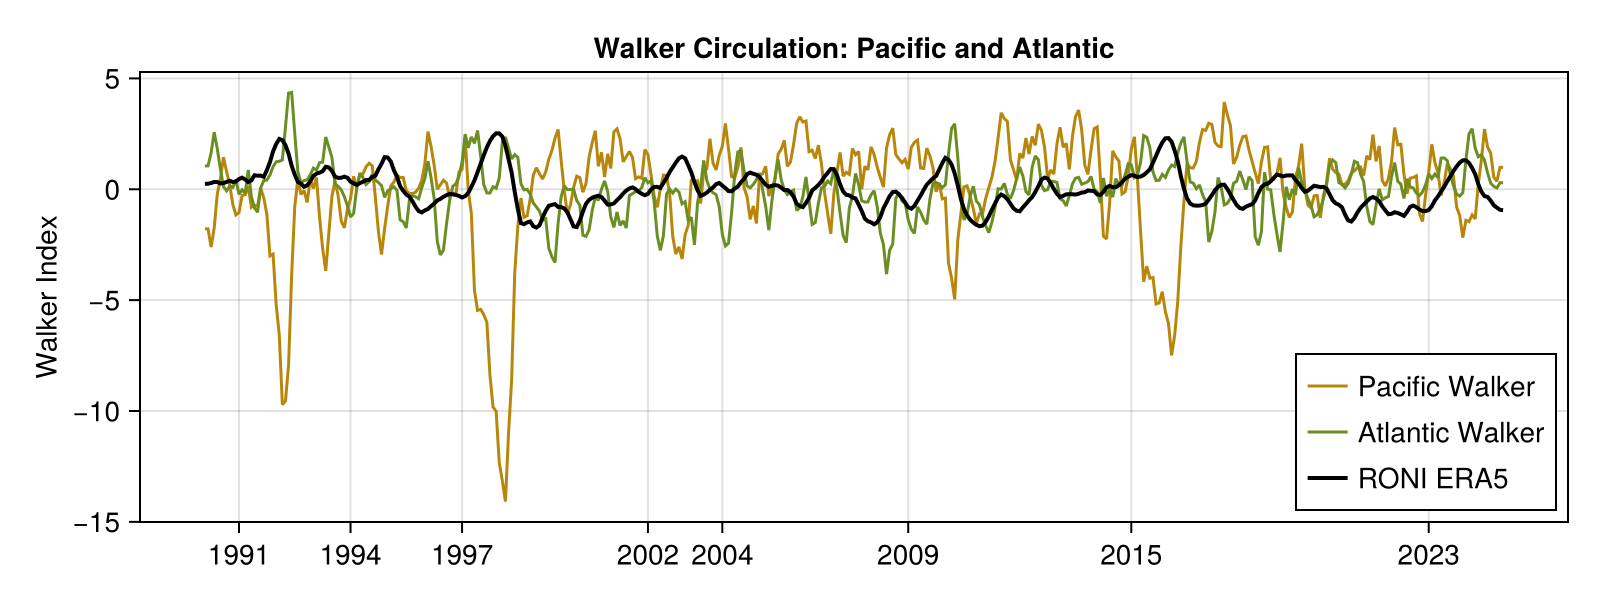

In [55]:
fig = Figure(;
    size = (800,300),
    )
ax = Axis(fig[1,1];
    xlabel=" ",
    ylabel="Walker Index",
    #xticks=([1990,1995,2000,2005,2010,2015,2020,2025]),
    xticks=([1991,1994,1997,2002,2004,2009,2015,2023]),
    title="Walker Circulation: Pacific and Atlantic"
    )
lines!(ax, timeAx,walk_pac_an[:],
    linewidth = 1.5,
    color = "darkgoldenrod",
    #color = "honeydew5",
    label = "Pacific Walker"
    )
lines!(ax, timeAx,box3_mn_an[:],
    linewidth = 1.5,
    #color = "honeydew3",
    color = "olivedrab",
    label = "Atlantic Walker"
    )
lines!(ax, timeAx,roni_era5[:],
    linewidth = 2.0,
    color = "black",
    label = "RONI ERA5"
    )
#lines!(ax, timeAx,ts_bx3_nsc[:],
#    linewidth = 1.00,
#    #color = "honeydew3",
#    color = "red",
#    label = "Atlantic Walker"
#    )
axislegend( position=:rb)
#box1_mn_sm
fig

In [29]:
save("WalkerTS_RONIera5.png", fig; px_per_unit=12.0)

In [60]:
size(box3_mn_an)

(420,)

In [31]:
size(roni_era5)

(420,)

In [61]:
RepSuck = cor(box3_mn_an,roni_era5)

0.13294613018849138

In [62]:
TruSuck = cor(walk_pac_an,roni_era5)

-0.6373940623823985

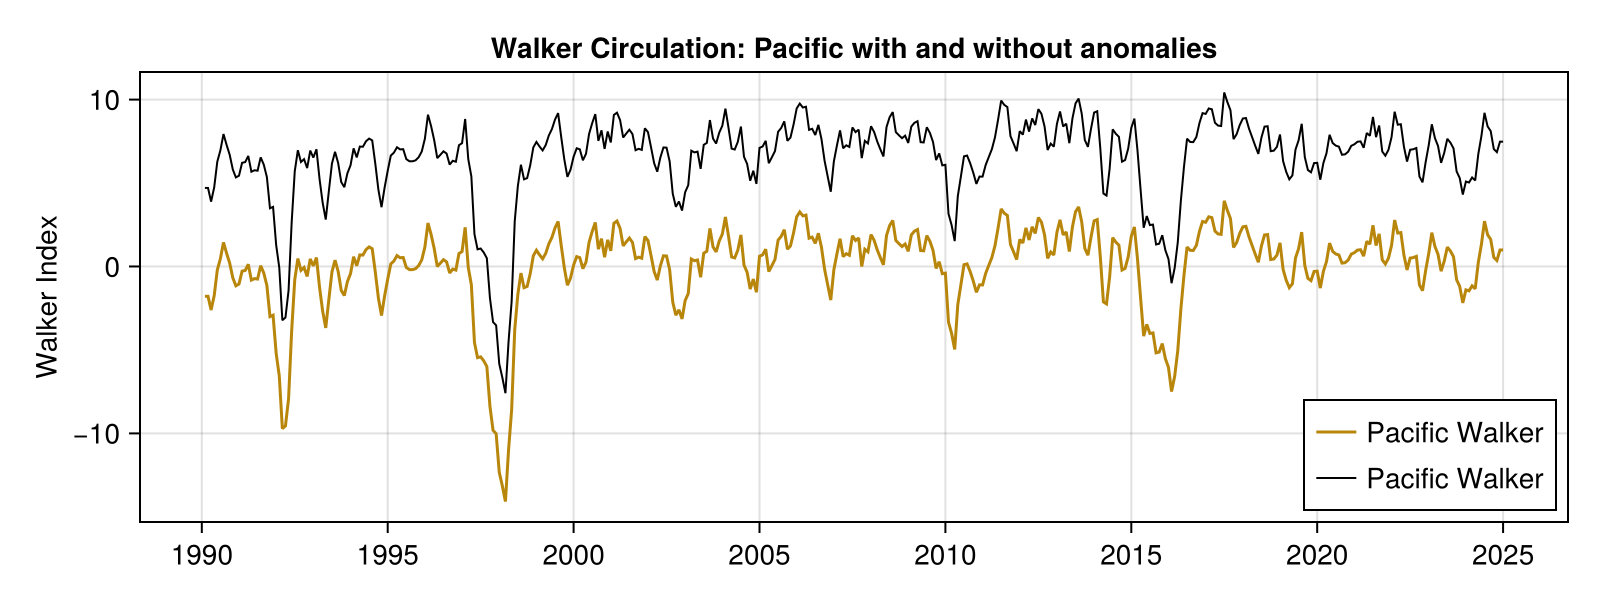

In [64]:
fig = Figure(;
    size = (800,300),
    )
ax = Axis(fig[1,1];
    xlabel=" ",
    ylabel="Walker Index",
    xticks=([1990,1995,2000,2005,2010,2015,2020,2025]),
    title="Walker Circulation: Pacific with and without anomalies"
    )
lines!(ax, timeAx,walk_pac_an[:],
    linewidth = 1.5,
    color = "darkgoldenrod",
    #color = "honeydew5",
    label = "Pacific Walker"
    )
lines!(ax, timeAx,walk_pac[:],
    linewidth = 1.00,
    color = "black",
    label = "Pacific Walker"
    )
axislegend( position=:rb)
fig